In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Quick look at our Data

In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

#### Check if there is any missing value

In [184]:
train.isnull().sum()
# No missing Value!

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

#### Then check is there any duplicated data

In [185]:
train.duplicated().sum()
# No duplicated data Nice!

0

#### Drop the 'id' column because we not need it in our training

In [186]:
train.drop(columns = ['id'], inplace = True)

### Exploratory data analysis

#### Let see what aged of people smoke the most

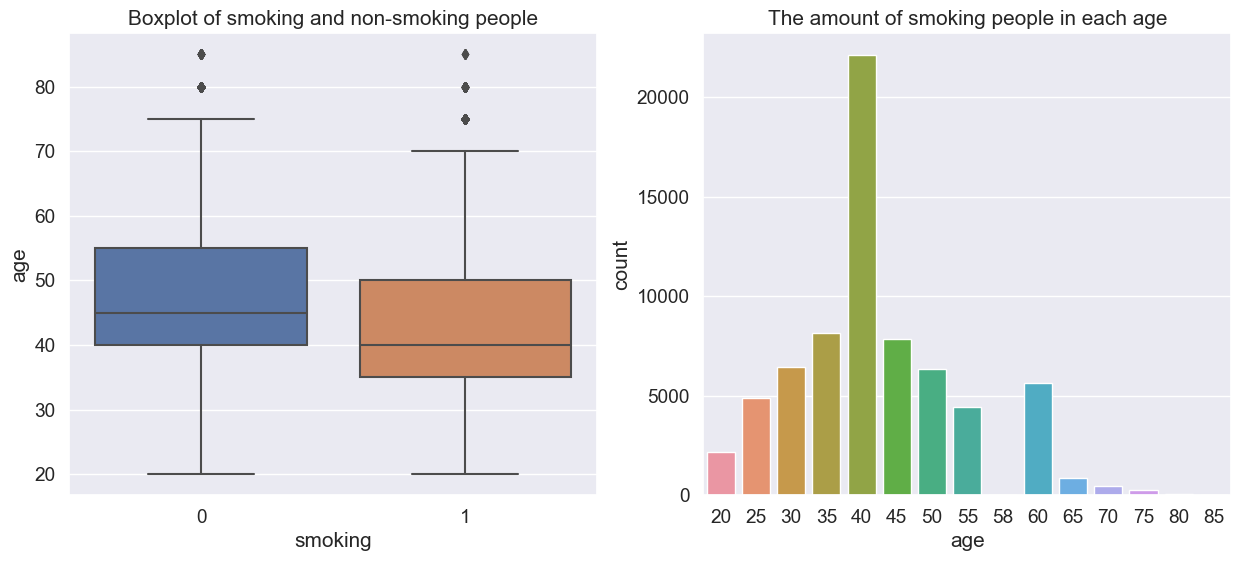

In [187]:
df = train[train['smoking'] == 1]
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
Box = sns.boxplot(ax = axes[0], data = train, x = 'smoking', y = 'age')
Box.title.set_text('Boxplot of smoking and non-smoking people')

count = sns.countplot(df, x = 'age',)
count.title.set_text('The amount of smoking people in each age')
plt.show()

##### Seem like smoking people have lower age in average, and most smoking people are in age 40

#### Let see does smoking have relative with **height** or **weight**

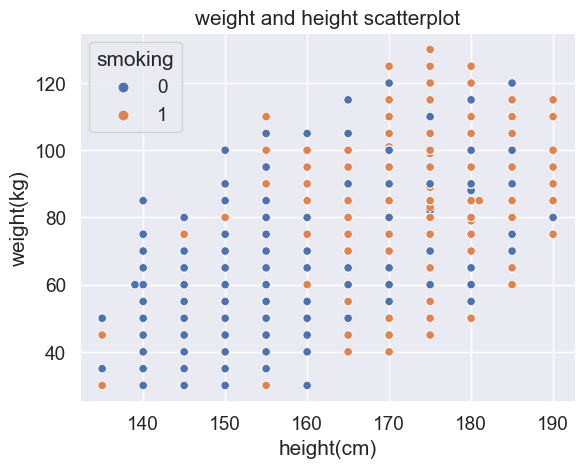

In [188]:
sns.scatterplot(data = train, x = 'height(cm)', y = 'weight(kg)', hue = 'smoking')
plt.title('weight and height scatterplot')
plt.show()

##### Seem like most smoking people have **higher height**, but I can't see the **weight** have strong relative with smoking

#### So let try to see **waist**

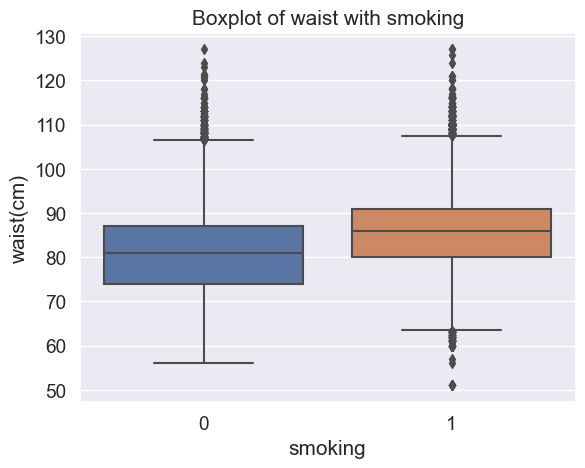

In [189]:
sns.boxplot(data = train, x = 'smoking', y = 'waist(cm)')
plt.title('Boxplot of waist with smoking')
plt.show()

##### We can see that smoking people have larger mean of **waist**

#### try to do some features transform with hearing

In [190]:
# Calculate Average Eyesight and Hearing
def feature_engineering(df):
    df['average_eyesight'] = (df['eyesight(left)'] + df['eyesight(right)']) / 2
    df['average_hearing'] = (df['hearing(left)'] + df['hearing(right)']) / 2
    return df

In [191]:
train = feature_engineering(train)
test = feature_engineering(test)

#### Let see each numeric variable distribution

##### reference by https://www.kaggle.com/code/kimtaehun/comprehensive-eda-to-xgboost-a-prediction

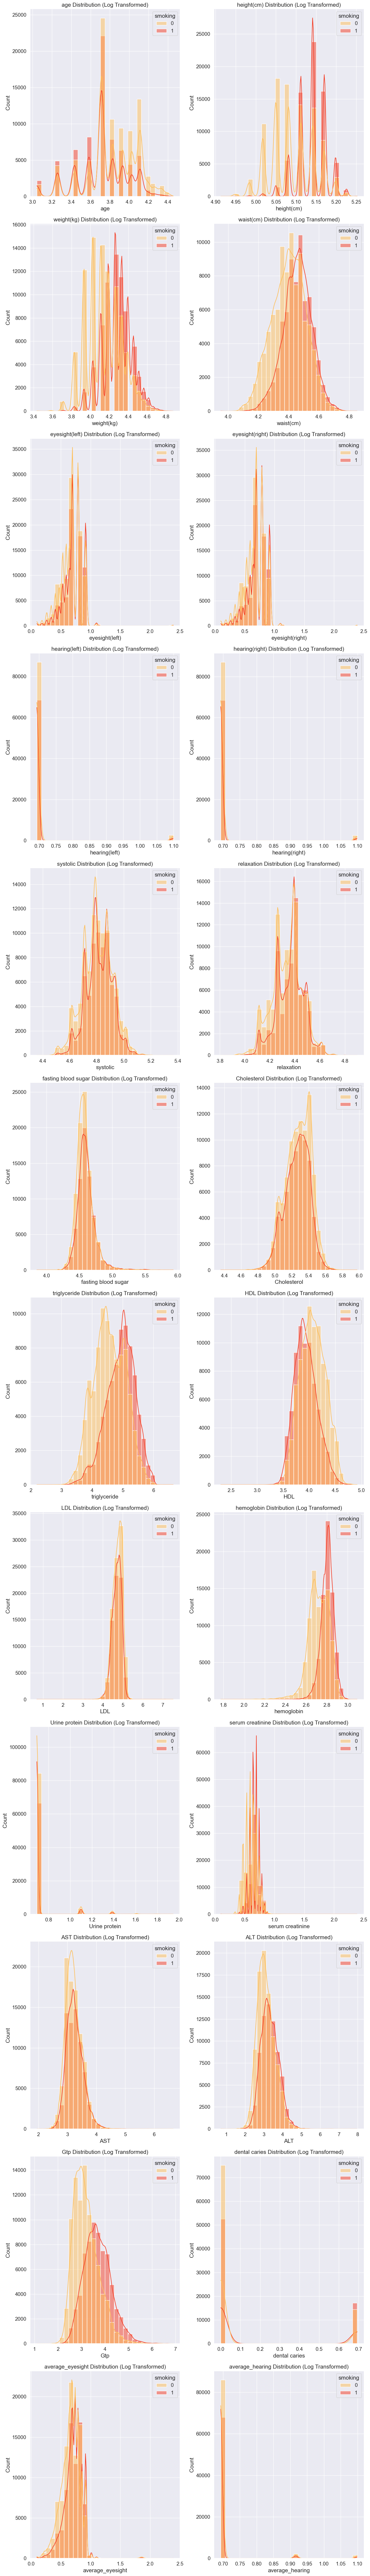

In [192]:
num_variable = train.select_dtypes(include = [np.number]).columns.tolist()
num_variable.remove('smoking')
# because there are a lot of data have **high skewed**, so we used log transform to deal with it.
for col in num_variable:
    train[col] = train[col].apply(lambda x: np.log(x+1))

plt.figure(figsize=(14, len(num_variable)*4))

for idx, cols in enumerate(num_variable):
    plt.subplot(len(num_variable)//2 + len(num_variable)%2, 2, idx+1)
    sns.histplot(data = train, x = cols, hue = 'smoking', bins = 30, kde = True, palette='YlOrRd')
    plt.title(f"{cols} Distribution (Log Transformed)")
    plt.tight_layout()
plt.show()

#### Let see the correlation

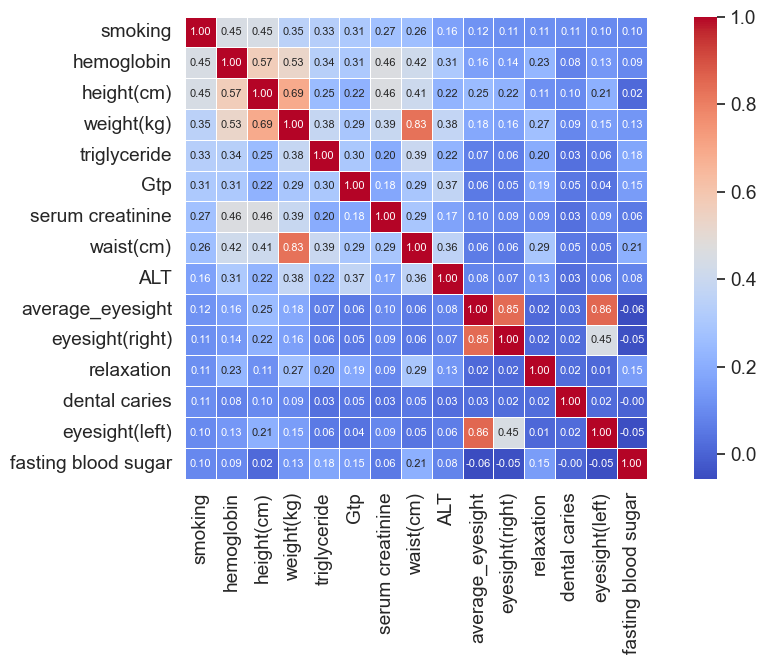

In [163]:
corrmat = train.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'smoking')['smoking'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (12,6))
hm = sns.heatmap(cm, cbar = True, annot = True, cmap = 'coolwarm', linewidths = .5, square = True, fmt = '.2f', annot_kws = {'size': 8}, yticklabels = cols.values, xticklabels = cols.values)
plt.show()

#### Machine Learning

##### Random Forest

In [193]:
rand_state = 42

##### Take our lables out of train Data

In [194]:
labels = train.smoking
train = train.drop(columns = 'smoking')

##### Split the Data into train and test, with 0.7train and 0.3 test

In [80]:
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size = 0.3, random_state = rand_state)

##### Let see the train and test data shape

In [81]:
print("Training dataset : ", x_train.shape,y_train.shape )
print("Testing dataset : ", x_test.shape, y_test.shape)

Training dataset :  (111479, 21) (111479,)
Testing dataset :  (47777, 21) (47777,)


##### Import Random Forest

In [86]:
# I did not spend time on setting hyperparameter
RF_classifier = RandomForestClassifier()
RF_classifier.fit(x_train, y_train)

RandomForestClassifier()

In [87]:
y_hat = RF_classifier.predict(x_test)

In [88]:
RF_classifier.score(x_test, y_test)

0.7735730581660631

#### Xgboost

##### Split the Data into train and test, with 0.7train and 0.3 test

In [195]:
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size = 0.3, random_state = 42)

##### Import XgboostClassifier and set the hyperparameter

In [196]:
from xgboost import XGBClassifier
xgboostModel = XGBClassifier(n_estimators = 300, learning_rate = 0.2, alpha = 10)
xgboostModel.fit(x_train, y_train)
predicted = xgboostModel.predict(x_train)

##### Print the train and test score

In [197]:
print('Training: ', xgboostModel.score(x_train, y_train))
print('Testing: ', xgboostModel.score(x_test, y_test))

Training:  0.835556472519488
Testing:  0.785063942901396


##### The accuracy is higher than Random Forest **0.01**, with less time.

#### Plot the Feature Importance

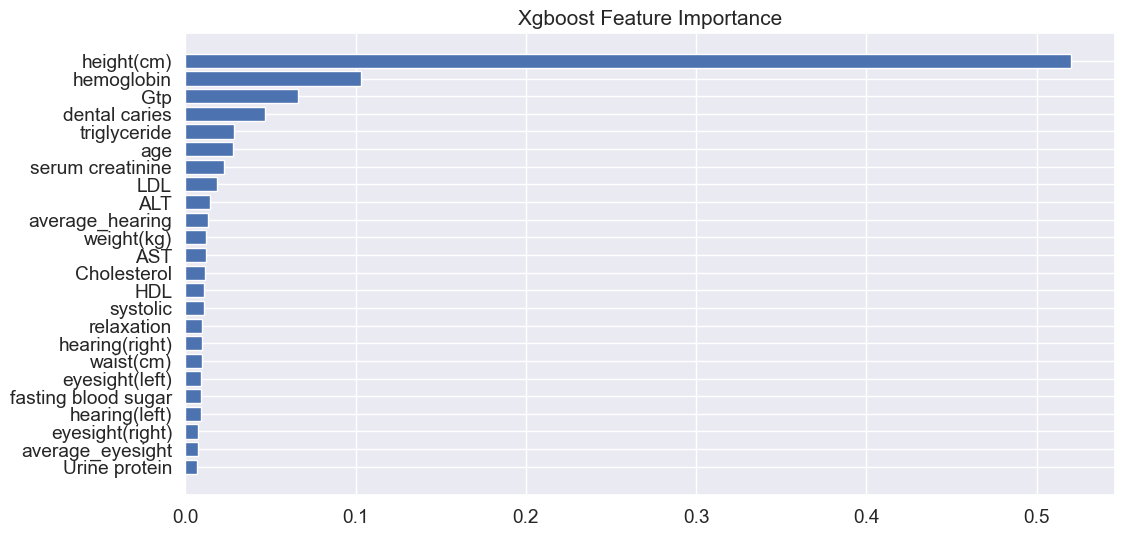

In [198]:
feature_importance = xgboostModel.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Xgboost Feature Importance')

plt.show()

#### Try the Test Data

In [42]:
Id = test.id
test = test.drop(columns = ['id'])
# transform the data
test = test.apply(lambda x: np.log(x+1))

#### Put the data into model

In [26]:
test_predict = xgboostModel.predict_proba(test)

##### See the result

In [27]:
result = pd.DataFrame({'Id': Id, 'smoking': test_predict[:,1]})
result

,Id,smoking
0,159256,0.568729
1,159257,0.472185
2,159258,0.391951
3,159259,0.008920
4,159260,0.647296
...,...,...
106166,265422,0.550251
106167,265423,0.619737
106168,265424,0.490384
106169,265425,0.107208


#### Submission

In [29]:
result.to_csv('Xgb_submission.csv', index = False)